In [1]:
# Data processing
import iris
import iris.analysis
import iris.coord_categorisation
import warnings
warnings.filterwarnings('ignore', module='iris')
import numpy as np
from pathlib import Path
from scipy import stats
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3)
def custom_ctcklbls(x, pos):
    '''Custom format for colorbar tick labels'''
    return '{:1.2f}'.format(x)
plt.rcParams['mathtext.default'] = 'regular'

In [2]:
# Choose variable
dir_var = 'oh'
str_var = 'OH'
coeff_var = (28.97/17.01) # coeff to convert mass mixing ratio to volume mixing ratio where M dry air = 28.97 [g mol-1]
# Read data
base = 'xnvtc'; sens = 'xnvth'; base_plt = 'CheT orig'; sens_plt = 'CheT revised'
path_to_ukca = Path('../data')

Na = 6.022*1e23 # [mol-1]
R = 8.314 # [J K-1 mol-1]
base_p = iris.load_cube(str(path_to_ukca / base / f'{base}_p.nc'))[:,0:33,...] # sample troposphere (up to 20 km)
base_t = iris.load_cube(str(path_to_ukca / base / f'{base}_temp.nc'))[:,0:33,...]
sens_p = iris.load_cube(str(path_to_ukca / sens / f'{sens}_p.nc'))[:,0:33,...]
sens_t = iris.load_cube(str(path_to_ukca / sens / f'{sens}_temp.nc'))[:,0:33,...]

base = iris.load_cube(str(path_to_ukca / base / f'{base}_{dir_var}.nc'))[:,0:33,...]*coeff_var*Na*base_p.data/(R*base_t.data)*1e-6 # in [cm-3]
sens = iris.load_cube(str(path_to_ukca / sens / f'{sens}_{dir_var}.nc'))[:,0:33,...]*coeff_var*Na*sens_p.data/(R*sens_t.data)*1e-6
# Path to figs
path_to_figs = Path('../../../results') / 'xnvth-xnvtc' / dir_var
path_to_figs.mkdir(exist_ok=True)
savefig = True

### Description of statistical analysis

1. Perform the Shapiro-Wilk test for normality. scipy docs: The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution. Wikipedia: if the p-value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p-value is greater than the chosen alpha level, then the null hypothesis that the data came from a normally distributed population can not be rejected. I.e. if p<0.05, data is not normal, if p>0.05, data is normal.
2. Perform paired samples t-test (https://pythonfordatascience.org/paired-samples-t-test-python/) if is data is normally distributed, or Wilcoxon signed-rank test (https://pythonfordatascience.org/wilcoxon-sign-ranked-test-python/) if data is not normally distributed.
2a. scipy docs: Paired samples t-test is a two-sided test for the null hypothesis that 2 related or repeated samples have identical average (expected) values. If we observe a large p-value, for example greater than 0.05 or 0.1 then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.
2b. scipy docs: The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero. It is a non-parametric version of the paired T-test. Because the normal approximation is used for the calculations, the samples used should be large. A typical rule is to require that n > 20. Currently my n=10...
3. Control false discovery rate. See https://en.wikipedia.org/wiki/False_discovery_rate, https://fabienmaussion.info/2017/01/30/trendy-triangles-fdr/, https://www.statisticshowto.datasciencecentral.com/false-discovery-rate/, https://www.statisticshowto.datasciencecentral.com/multiple-testing-problem/

Explanation of the difference between using one sample and paired samples tests: http://benalexkeen.com/comparative-statistics-in-python-using-scipy/

In [3]:
def fdr_threshold(pvalues, alpha=0.05*2):
    '''Compute the FDR threshod after Wilks (2016).
    Credit to https://fabienmaussion.info/2017/01/30/trendy-triangles-fdr/'''
    p = np.sort(np.asarray(pvalues).flatten())
    n = len(p)
    return np.max(np.where(p <= np.arange(1, n+1) / n * alpha, p, 0))

In [4]:
# Add season and year coordinates
iris.coord_categorisation.add_season(base, 'time', name='season')
iris.coord_categorisation.add_season(sens, 'time', name='season')
iris.coord_categorisation.add_season_year(base, 'time', name='year')
iris.coord_categorisation.add_season_year(sens, 'time', name='year')
# # Replace last January's year with first February's year
# base.coord('year').points = np.array([2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006,
#                                       2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007,
#                                       2007, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008,
#                                       2008, 2008, 2006])
# sens.coord('year').points = base.coord('year').points
str_djf = 'DJF'; str_mam = 'MAM'; str_jja = 'JJA'; str_son = 'SON'

### Zonal seasonal means

In [5]:
# Calculate zonal mean for each month
base_znl_mean = base.collapsed('longitude', iris.analysis.MEAN)
sens_znl_mean = sens.collapsed('longitude', iris.analysis.MEAN)
# Extract time series of zonal seasonal means
base_znl_djf = base_znl_mean.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_djf = sens_znl_mean.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
base_znl_mam = base_znl_mean.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_mam = sens_znl_mean.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
base_znl_jja = base_znl_mean.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_jja = sens_znl_mean.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
base_znl_son = base_znl_mean.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
sens_znl_son = sens_znl_mean.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)
# Check if zonal seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
nlevs = base.coord('level_height').shape[0]
nlats = base.coord('latitude').shape[0]
shapiro_znl_djf_p = np.empty([nlevs,nlats])
shapiro_znl_mam_p = np.empty([nlevs,nlats])
shapiro_znl_jja_p = np.empty([nlevs,nlats])
shapiro_znl_son_p = np.empty([nlevs,nlats])
for i, lev in enumerate(base.coord('level_height').points):
    for j, lat in enumerate(base.coord('latitude').points):
        shapiro_znl_djf_p[i,j] = stats.shapiro(base_znl_djf.data[:,i,j] - sens_znl_djf.data[:,i,j])[1]
        shapiro_znl_mam_p[i,j] = stats.shapiro(base_znl_mam.data[:,i,j] - sens_znl_mam.data[:,i,j])[1]
        shapiro_znl_jja_p[i,j] = stats.shapiro(base_znl_jja.data[:,i,j] - sens_znl_jja.data[:,i,j])[1]
        shapiro_znl_son_p[i,j] = stats.shapiro(base_znl_son.data[:,i,j] - sens_znl_son.data[:,i,j])[1]
# See if zonal seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
znl_djf_p = np.empty([nlevs,nlats])
znl_mam_p = np.empty([nlevs,nlats])
znl_jja_p = np.empty([nlevs,nlats])
znl_son_p = np.empty([nlevs,nlats])
for i, lev in enumerate(base.coord('level_height').points):
    for j, lat in enumerate(base.coord('latitude').points):
        if shapiro_znl_djf_p[i,j] > 0.05:
            znl_djf_p[i,j] = stats.ttest_rel(base_znl_djf.data[:,i,j], sens_znl_djf.data[:,i,j])[1]
        else: 
            znl_djf_p[i,j] = stats.wilcoxon(base_znl_djf.data[:,i,j], sens_znl_djf.data[:,i,j])[1]
        if shapiro_znl_mam_p[i,j] > 0.05:
            znl_mam_p[i,j] = stats.ttest_rel(base_znl_mam.data[:,i,j], sens_znl_mam.data[:,i,j])[1]
        else:
            znl_mam_p[i,j] = stats.wilcoxon(base_znl_mam.data[:,i,j], sens_znl_mam.data[:,i,j])[1]
        if shapiro_znl_jja_p[i,j] > 0.05:
            znl_jja_p[i,j] = stats.ttest_rel(base_znl_jja.data[:,i,j], sens_znl_jja.data[:,i,j])[1]
        else:
            znl_jja_p[i,j] = stats.wilcoxon(base_znl_jja.data[:,i,j], sens_znl_jja.data[:,i,j])[1]
        if shapiro_znl_son_p[i,j] > 0.05:
            znl_son_p[i,j] = stats.ttest_rel(base_znl_son.data[:,i,j], sens_znl_son.data[:,i,j])[1]
        else:
            znl_son_p[i,j] = stats.wilcoxon(base_znl_son.data[:,i,j], sens_znl_son.data[:,i,j])[1]
# Calculate zonal seasonal mean differences
base_znl_djf_mean = base_znl_djf.collapsed('year', iris.analysis.MEAN)
base_znl_mam_mean = base_znl_mam.collapsed('year', iris.analysis.MEAN)
base_znl_jja_mean = base_znl_jja.collapsed('year', iris.analysis.MEAN)
base_znl_son_mean = base_znl_son.collapsed('year', iris.analysis.MEAN)
sens_znl_djf_mean = sens_znl_djf.collapsed('year', iris.analysis.MEAN)
sens_znl_mam_mean = sens_znl_mam.collapsed('year', iris.analysis.MEAN)
sens_znl_jja_mean = sens_znl_jja.collapsed('year', iris.analysis.MEAN)
sens_znl_son_mean = sens_znl_son.collapsed('year', iris.analysis.MEAN)
znl_djf_diff = sens_znl_djf_mean - base_znl_djf_mean
znl_mam_diff = sens_znl_mam_mean - base_znl_mam_mean
znl_jja_diff = sens_znl_jja_mean - base_znl_jja_mean
znl_son_diff = sens_znl_son_mean - base_znl_son_mean
# Find max zonal seasonal mean
print(f'{max(np.max(base_znl_djf_mean.data), np.max(sens_znl_djf_mean.data)):0.2e}')
print(f'{max(np.max(base_znl_mam_mean.data), np.max(sens_znl_mam_mean.data)):0.2e}')
print(f'{max(np.max(base_znl_jja_mean.data), np.max(sens_znl_jja_mean.data)):0.2e}')
print(f'{max(np.max(base_znl_son_mean.data), np.max(sens_znl_son_mean.data)):0.2e}')
# Check for false discovery
print('FDR: ', fdr_threshold(znl_djf_p), fdr_threshold(znl_mam_p), fdr_threshold(znl_jja_p), fdr_threshold(znl_son_p))

1.91e+06
2.33e+06
3.27e+06
1.72e+06
FDR:  0.0 0.0 0.0069104298078147995 0.005231980630452996


In [6]:
# Zonal seasonal mean plotting parameters
znl_mean_cf_kwargs = dict(levels=np.arange(0,4e6,0.5e6))
znl_mean_pc_kwargs = dict(cmap='RdBu_r')
znl_mean_cr_kwargs = dict(levels=[-10,-5,0,5,10], cmap='RdBu_r')
znl_pval_kwargs = dict(s=5, c='k', marker='.', alpha=1)
fdr_znl = True # turn FDR on/off
def stipple_zonal(cube, pval_arr, fdr):
    '''Stipple areas where p-values are statistically significant. 
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
    xOrg = cube.coord('latitude').points 
    yOrg = cube.coord('level_height').points
    nlon = len(xOrg) 
    nlat = len(yOrg) 
    xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
    yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape )
    if fdr:
        thresh = fdr_threshold(pval_arr) # false discovery rate threshold
    else:
        thresh = 0.05
    sigPoints = pval_arr < thresh 
    xPoints = xData[sigPoints]
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)
lats = base.coord('latitude').points
levs = base.coord('level_height').points

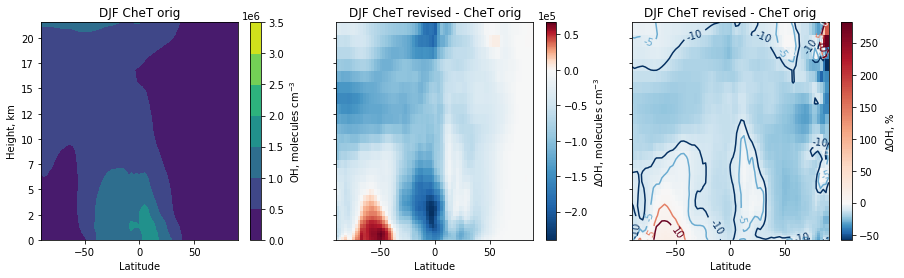

In [7]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4), facecolor='w', sharex=True, sharey=True)
p00 = ax[0].contourf(lats, levs, base_znl_djf_mean.data, **znl_mean_cf_kwargs)
p01 = ax[1].pcolormesh(lats, levs, znl_djf_diff.data, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
p02 = ax[2].pcolormesh(lats, levs, znl_djf_diff.data/base_znl_djf_mean.data*100, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
p02x = ax[2].contour(lats, levs, znl_djf_diff.data/base_znl_djf_mean.data*100, **znl_mean_cr_kwargs)
ax[2].clabel(p02x, inline=1, fmt='%1.0f')
ax[0].set_title(f'{str_djf} {base_plt}')
ax[1].set_title(f'{str_djf} {sens_plt} - {base_plt}')
ax[2].set_title(f'{str_djf} {sens_plt} - {base_plt}')
ax[0].set_ylabel('Height, km')
cbar0 = fig.colorbar(p00, ax=ax[0], label=f'{str_var}, molecules $cm^{{-3}}$')
cbar1 = fig.colorbar(p01, ax=ax[1], label=f'$\Delta${str_var}, molecules $cm^{{-3}}$')
fig.colorbar(p02, ax=ax[2], label=f'$\Delta${str_var}, %')
for icbar in [cbar0, cbar1]:
    icbar.formatter.set_powerlimits((0, 0))
    icbar.update_ticks()
for iax in ax.flatten()[1:3]: iax.scatter(*stipple_zonal(znl_djf_diff, znl_djf_p, fdr_znl), **znl_pval_kwargs)
for iax in ax.flatten():
    iax.margins(x=0, y=0)
    iax.set_xlabel('Latitude')
    iax.yaxis.set_major_formatter(FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{dir_var}_znl_seas_mean_{str_djf}.png', bbox_inches='tight')

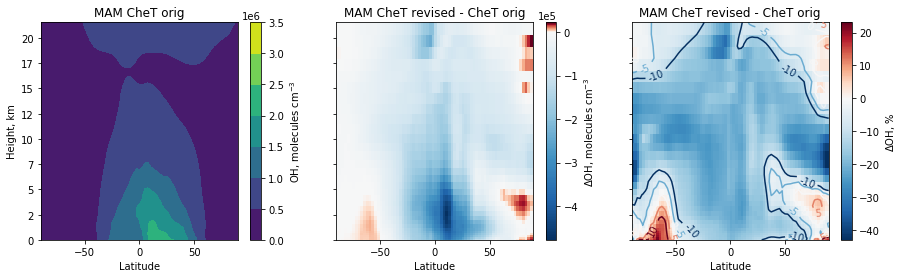

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4), facecolor='w', sharex=True, sharey=True)
p00 = ax[0].contourf(lats, levs, base_znl_mam_mean.data, **znl_mean_cf_kwargs)
p01 = ax[1].pcolormesh(lats, levs, znl_mam_diff.data, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
p02 = ax[2].pcolormesh(lats, levs, znl_mam_diff.data/base_znl_mam_mean.data*100, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
p02x = ax[2].contour(lats, levs, znl_mam_diff.data/base_znl_mam_mean.data*100, **znl_mean_cr_kwargs)
ax[2].clabel(p02x, inline=1, fmt='%1.0f')
ax[0].set_title(f'{str_mam} {base_plt}')
ax[1].set_title(f'{str_mam} {sens_plt} - {base_plt}')
ax[2].set_title(f'{str_mam} {sens_plt} - {base_plt}')
ax[0].set_ylabel('Height, km')
cbar0 = fig.colorbar(p00, ax=ax[0], label=f'{str_var}, molecules $cm^{{-3}}$')
cbar1 = fig.colorbar(p01, ax=ax[1], label=f'$\Delta${str_var}, molecules $cm^{{-3}}$')
fig.colorbar(p02, ax=ax[2], label=f'$\Delta${str_var}, %')
for icbar in [cbar0, cbar1]:
    icbar.formatter.set_powerlimits((0, 0))
    icbar.update_ticks()
for iax in ax.flatten()[1:3]: iax.scatter(*stipple_zonal(znl_mam_diff, znl_mam_p, fdr_znl), **znl_pval_kwargs)
for iax in ax.flatten():
    iax.margins(x=0, y=0)
    iax.set_xlabel('Latitude')
    iax.yaxis.set_major_formatter(FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{dir_var}_znl_seas_mean_{str_mam}.png', bbox_inches='tight')

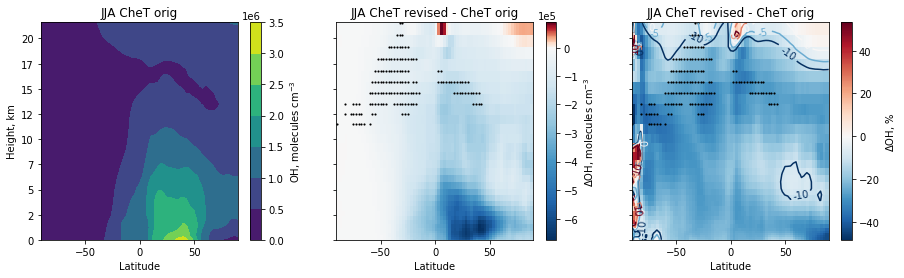

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4), facecolor='w', sharex=True, sharey=True)
p00 = ax[0].contourf(lats, levs, base_znl_jja_mean.data, **znl_mean_cf_kwargs)
p01 = ax[1].pcolormesh(lats, levs, znl_jja_diff.data, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
p02 = ax[2].pcolormesh(lats, levs, znl_jja_diff.data/base_znl_jja_mean.data*100, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
p02x = ax[2].contour(lats, levs, znl_jja_diff.data/base_znl_jja_mean.data*100, **znl_mean_cr_kwargs)
ax[2].clabel(p02x, inline=1, fmt='%1.0f')
ax[0].set_title(f'{str_jja} {base_plt}')
ax[1].set_title(f'{str_jja} {sens_plt} - {base_plt}')
ax[2].set_title(f'{str_jja} {sens_plt} - {base_plt}')
ax[0].set_ylabel('Height, km')
cbar0 = fig.colorbar(p00, ax=ax[0], label=f'{str_var}, molecules $cm^{{-3}}$')
cbar1 = fig.colorbar(p01, ax=ax[1], label=f'$\Delta${str_var}, molecules $cm^{{-3}}$')
fig.colorbar(p02, ax=ax[2], label=f'$\Delta${str_var}, %')
for icbar in [cbar0, cbar1]:
    icbar.formatter.set_powerlimits((0, 0))
    icbar.update_ticks()
for iax in ax.flatten()[1:3]: iax.scatter(*stipple_zonal(znl_jja_diff, znl_jja_p, fdr_znl), **znl_pval_kwargs)
for iax in ax.flatten():
    iax.margins(x=0, y=0)
    iax.set_xlabel('Latitude')
    iax.yaxis.set_major_formatter(FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{dir_var}_znl_seas_mean_{str_jja}.png', bbox_inches='tight')

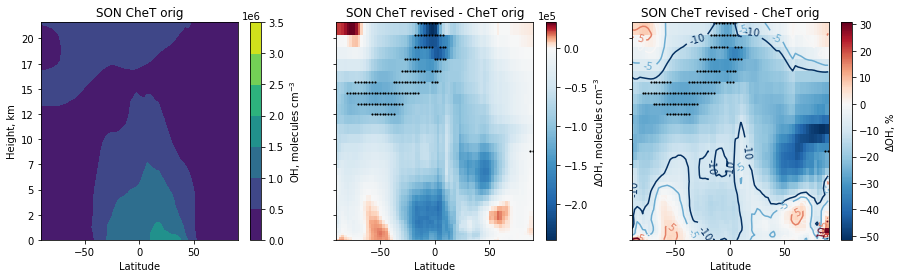

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4), facecolor='w', sharex=True, sharey=True)
p00 = ax[0].contourf(lats, levs, base_znl_son_mean.data, **znl_mean_cf_kwargs)
p01 = ax[1].pcolormesh(lats, levs, znl_son_diff.data, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
p02 = ax[2].pcolormesh(lats, levs, znl_son_diff.data/base_znl_son_mean.data*100, norm=MidpointNormalize(midpoint=0.), **znl_mean_pc_kwargs)
p02x = ax[2].contour(lats, levs, znl_son_diff.data/base_znl_son_mean.data*100, **znl_mean_cr_kwargs)
ax[2].clabel(p02x, inline=1, fmt='%1.0f')
ax[0].set_title(f'{str_son} {base_plt}')
ax[1].set_title(f'{str_son} {sens_plt} - {base_plt}')
ax[2].set_title(f'{str_son} {sens_plt} - {base_plt}')
ax[0].set_ylabel('Height, km')
cbar0 = fig.colorbar(p00, ax=ax[0], label=f'{str_var}, molecules $cm^{{-3}}$')
cbar1 = fig.colorbar(p01, ax=ax[1], label=f'$\Delta${str_var}, molecules $cm^{{-3}}$')
fig.colorbar(p02, ax=ax[2], label=f'$\Delta${str_var}, %')
for icbar in [cbar0, cbar1]:
    icbar.formatter.set_powerlimits((0, 0))
    icbar.update_ticks()
for iax in ax.flatten()[1:3]: iax.scatter(*stipple_zonal(znl_son_diff, znl_son_p, fdr_znl), **znl_pval_kwargs)
for iax in ax.flatten():
    iax.margins(x=0, y=0)
    iax.set_xlabel('Latitude')
    iax.yaxis.set_major_formatter(FuncFormatter(m2km))
if savefig: fig.savefig(path_to_figs / f'{dir_var}_znl_seas_mean_{str_son}.png', bbox_inches='tight')

#### Zonal seasonal means summary

In [11]:
# Find min and max absolute zonal seasonal mean difference
print(f'{min([np.min(znl_djf_diff.data), np.min(znl_mam_diff.data), np.min(znl_jja_diff.data), np.min(znl_son_diff.data)]):0.2e}')
print(f'{max([np.max(znl_djf_diff.data), np.max(znl_mam_diff.data), np.max(znl_jja_diff.data), np.max(znl_son_diff.data)]):0.2e}')
# Find min and max % zonal seasonal mean difference
print(min([np.min(znl_djf_diff.data/base_znl_djf_mean.data*100), np.min(znl_mam_diff.data/base_znl_mam_mean.data*100), 
           np.min(znl_jja_diff.data/base_znl_jja_mean.data*100), np.min(znl_son_diff.data/base_znl_son_mean.data*100)]))
print(max([np.max(znl_djf_diff.data/base_znl_djf_mean.data*100), np.max(znl_mam_diff.data/base_znl_mam_mean.data*100), 
           np.max(znl_jja_diff.data/base_znl_jja_mean.data*100), np.max(znl_son_diff.data/base_znl_son_mean.data*100)]))

-6.74e+05
8.76e+04
-82.79658925946586
281.65149655309074


In [12]:
# Additional plotting parameters for zonal seasonal mean summary
znl_glb_absdiff_pc_kwargs = dict(cmap='RdBu_r', vmin=-7e5, vmax=7e5)
znl_glb_pctdiff_pc_kwargs = dict(cmap='RdBu_r', vmin=-100, vmax=100)

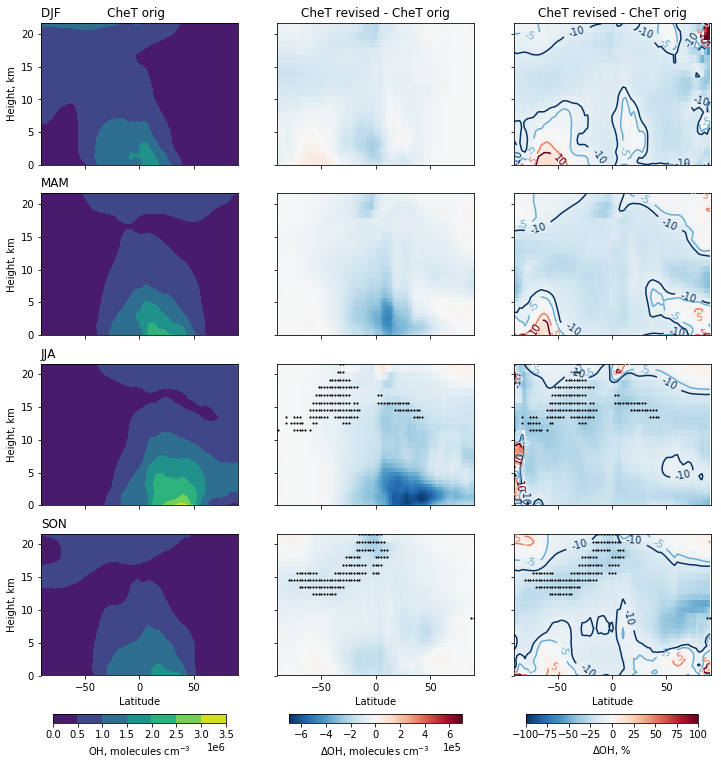

In [15]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,12), facecolor='w', sharex=True, sharey=True)
ax[0,0].contourf(lats, levs, base_znl_djf_mean.data, **znl_mean_cf_kwargs)
ax[0,1].pcolormesh(lats, levs, znl_djf_diff.data, **znl_glb_absdiff_pc_kwargs)
ax[0,2].pcolormesh(lats, levs, znl_djf_diff.data/base_znl_djf_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
p02x = ax[0,2].contour(lats, levs, znl_djf_diff.data/base_znl_djf_mean.data*100, **znl_mean_cr_kwargs)
ax[0,2].clabel(p02x, inline=1, fmt='%1.0f')

ax[1,0].contourf(lats, levs, base_znl_mam_mean.data, **znl_mean_cf_kwargs)
ax[1,1].pcolormesh(lats, levs, znl_mam_diff.data, **znl_glb_absdiff_pc_kwargs)
ax[1,2].pcolormesh(lats, levs, znl_mam_diff.data/base_znl_mam_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
p12x = ax[1,2].contour(lats, levs, znl_mam_diff.data/base_znl_mam_mean.data*100, **znl_mean_cr_kwargs)
ax[1,2].clabel(p12x, inline=1, fmt='%1.0f')

ax[2,0].contourf(lats, levs, base_znl_jja_mean.data, **znl_mean_cf_kwargs)
ax[2,1].pcolormesh(lats, levs, znl_jja_diff.data, **znl_glb_absdiff_pc_kwargs)
ax[2,2].pcolormesh(lats, levs, znl_jja_diff.data/base_znl_jja_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
p22x = ax[2,2].contour(lats, levs, znl_jja_diff.data/base_znl_jja_mean.data*100, **znl_mean_cr_kwargs)
ax[2,2].clabel(p22x, inline=1, fmt='%1.0f')

p30 = ax[3,0].contourf(lats, levs, base_znl_son_mean.data, **znl_mean_cf_kwargs)
p31 = ax[3,1].pcolormesh(lats, levs, znl_son_diff.data, **znl_glb_absdiff_pc_kwargs)
p32 = ax[3,2].pcolormesh(lats, levs, znl_son_diff.data/base_znl_son_mean.data*100, **znl_glb_pctdiff_pc_kwargs)
p32x = ax[3,2].contour(lats, levs, znl_son_diff.data/base_znl_son_mean.data*100, **znl_mean_cr_kwargs)
ax[3,2].clabel(p32x, inline=1, fmt='%1.0f')

cax0 = fig.add_axes([0.139, 0.07, 0.2, 0.01])
cax1 = fig.add_axes([0.412, 0.07, 0.2, 0.01])
cax2 = fig.add_axes([0.686, 0.07, 0.2, 0.01])
cbar0 = fig.colorbar(p30, cax=cax0, orientation='horizontal', label=f'{str_var}, molecules $cm^{{-3}}$')
cbar1 = fig.colorbar(p31, cax=cax1, orientation='horizontal', label=f'$\Delta${str_var}, molecules $cm^{{-3}}$')
fig.colorbar(p32, cax=cax2, orientation='horizontal', label=f'$\Delta${str_var}, %')
for icbar in [cbar0, cbar1]:
    icbar.formatter.set_powerlimits((0, 0))
    icbar.update_ticks()
ax[0,0].set_title(f'{str_djf}            {base_plt}', loc='left')
ax[0,1].set_title(f'{sens_plt} - {base_plt}')
ax[0,2].set_title(f'{sens_plt} - {base_plt}')
ax[1,0].set_title(f'{str_mam}', loc='left')
ax[2,0].set_title(f'{str_jja}', loc='left')
ax[3,0].set_title(f'{str_son}', loc='left')
for iax in ax[:,0].flatten(): iax.set_ylabel('Height, km')
for iax in ax[3,:].flatten(): iax.set_xlabel('Latitude')
for iax in ax.flatten():
    iax.margins(x=0, y=0)
    iax.yaxis.set_major_formatter(FuncFormatter(m2km))
for iax in ax[0,1:3].flatten(): iax.scatter(*stipple_zonal(znl_djf_diff, znl_djf_p, fdr_znl), **znl_pval_kwargs)
for iax in ax[1,1:3].flatten(): iax.scatter(*stipple_zonal(znl_mam_diff, znl_mam_p, fdr_znl), **znl_pval_kwargs)
for iax in ax[2,1:3].flatten(): iax.scatter(*stipple_zonal(znl_jja_diff, znl_jja_p, fdr_znl), **znl_pval_kwargs)
for iax in ax[3,1:3].flatten(): iax.scatter(*stipple_zonal(znl_son_diff, znl_son_p, fdr_znl), **znl_pval_kwargs)
if savefig: fig.savefig(path_to_figs / f'{dir_var}_znl_seas_mean_all.png', bbox_inches='tight')

In [14]:
break

SyntaxError: 'break' outside loop (cell_name, line 4)

### Surface seasonal means

In [ ]:
# Extract time series of surface seasonal means
base_srf_djf = base.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_djf = sens.extract(iris.Constraint(season='djf')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
base_srf_mam = base.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_mam = sens.extract(iris.Constraint(season='mam')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
base_srf_jja = base.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_jja = sens.extract(iris.Constraint(season='jja')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
base_srf_son = base.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
sens_srf_son = sens.extract(iris.Constraint(season='son')).aggregated_by(['year', 'season'], iris.analysis.MEAN)[:,0,...]
# Check if surface seasonal mean differences between two experiments are normally distributed using the Shapiro–Wilk test
nlons = base.coord('longitude').shape[0]
shapiro_srf_djf_p = np.empty([nlats,nlons])
shapiro_srf_mam_p = np.empty([nlats,nlons])
shapiro_srf_jja_p = np.empty([nlats,nlons])
shapiro_srf_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        shapiro_srf_djf_p[i,j] = stats.shapiro(base_srf_djf.data[:,i,j] - sens_srf_djf.data[:,i,j])[1]
        shapiro_srf_mam_p[i,j] = stats.shapiro(base_srf_mam.data[:,i,j] - sens_srf_mam.data[:,i,j])[1]
        shapiro_srf_jja_p[i,j] = stats.shapiro(base_srf_jja.data[:,i,j] - sens_srf_jja.data[:,i,j])[1]
        shapiro_srf_son_p[i,j] = stats.shapiro(base_srf_son.data[:,i,j] - sens_srf_son.data[:,i,j])[1]
# See if surface seasonal mean differences between two experiments are statitically significant using
# (a) paired sample t-test if data is normally distributed, and
# (b) Wilcoxon signed-rank test if data is not normally distributed
srf_djf_p = np.empty([nlats,nlons])
srf_mam_p = np.empty([nlats,nlons])
srf_jja_p = np.empty([nlats,nlons])
srf_son_p = np.empty([nlats,nlons])
for i, lat in enumerate(base.coord('latitude').points):
    for j, lon in enumerate(base.coord('longitude').points):
        if shapiro_srf_djf_p[i,j] > 0.05:
            srf_djf_p[i,j] = stats.ttest_rel(base_srf_djf.data[:,i,j], sens_srf_djf.data[:,i,j])[1]
        else: 
            srf_djf_p[i,j] = stats.wilcoxon(base_srf_djf.data[:,i,j], sens_srf_djf.data[:,i,j])[1]
        if shapiro_srf_mam_p[i,j] > 0.05:
            srf_mam_p[i,j] = stats.ttest_rel(base_srf_mam.data[:,i,j], sens_srf_mam.data[:,i,j])[1]
        else:
            srf_mam_p[i,j] = stats.wilcoxon(base_srf_mam.data[:,i,j], sens_srf_mam.data[:,i,j])[1]
        if shapiro_srf_jja_p[i,j] > 0.05:
            srf_jja_p[i,j] = stats.ttest_rel(base_srf_jja.data[:,i,j], sens_srf_jja.data[:,i,j])[1]
        else:
            srf_jja_p[i,j] = stats.wilcoxon(base_srf_jja.data[:,i,j], sens_srf_jja.data[:,i,j])[1]
        if shapiro_srf_son_p[i,j] > 0.05:
            srf_son_p[i,j] = stats.ttest_rel(base_srf_son.data[:,i,j], sens_srf_son.data[:,i,j])[1]
        else:
            srf_son_p[i,j] = stats.wilcoxon(base_srf_son.data[:,i,j], sens_srf_son.data[:,i,j])[1]
#         # Welch's t-test
#         srf_djf_p[i, j] = stats.ttest_ind(base_srf_djf.data[:,i,j], sens_srf_djf.data[:,i,j], equal_var=False)[1]
#         srf_mam_p[i, j] = stats.ttest_ind(base_srf_mam.data[:,i,j], sens_srf_mam.data[:,i,j], equal_var=False)[1]
#         srf_jja_p[i, j] = stats.ttest_ind(base_srf_jja.data[:,i,j], sens_srf_jja.data[:,i,j], equal_var=False)[1]
#         srf_son_p[i, j] = stats.ttest_ind(base_srf_son.data[:,i,j], sens_srf_son.data[:,i,j], equal_var=False)[1]
# Calculate surface seasonal mean differences
base_srf_djf_mean = base_srf_djf.collapsed('year', iris.analysis.MEAN)
base_srf_mam_mean = base_srf_mam.collapsed('year', iris.analysis.MEAN)
base_srf_jja_mean = base_srf_jja.collapsed('year', iris.analysis.MEAN)
base_srf_son_mean = base_srf_son.collapsed('year', iris.analysis.MEAN)
sens_srf_djf_mean = sens_srf_djf.collapsed('year', iris.analysis.MEAN)
sens_srf_mam_mean = sens_srf_mam.collapsed('year', iris.analysis.MEAN)
sens_srf_jja_mean = sens_srf_jja.collapsed('year', iris.analysis.MEAN)
sens_srf_son_mean = sens_srf_son.collapsed('year', iris.analysis.MEAN)
srf_djf_diff = sens_srf_djf_mean - base_srf_djf_mean
srf_mam_diff = sens_srf_mam_mean - base_srf_mam_mean
srf_jja_diff = sens_srf_jja_mean - base_srf_jja_mean
srf_son_diff = sens_srf_son_mean - base_srf_son_mean
# Add cyclic point for plotting on a global map
cyc_djf_diff, cyclic_lons = cartopy.util.add_cyclic_point(srf_djf_diff.data, coord=srf_djf_diff.coord('longitude').points)
cyc_mam_diff = cartopy.util.add_cyclic_point(srf_mam_diff.data)
cyc_jja_diff = cartopy.util.add_cyclic_point(srf_jja_diff.data)
cyc_son_diff = cartopy.util.add_cyclic_point(srf_son_diff.data)
cyc_base_srf_djf_mean = cartopy.util.add_cyclic_point(base_srf_djf_mean.data)
cyc_base_srf_mam_mean = cartopy.util.add_cyclic_point(base_srf_mam_mean.data)
cyc_base_srf_jja_mean = cartopy.util.add_cyclic_point(base_srf_jja_mean.data)
cyc_base_srf_son_mean = cartopy.util.add_cyclic_point(base_srf_son_mean.data)
# Find max surface seasonal mean
print(max(np.max(base_srf_djf_mean.data), np.max(sens_srf_djf_mean.data)))
print(max(np.max(base_srf_mam_mean.data), np.max(sens_srf_mam_mean.data)))
print(max(np.max(base_srf_jja_mean.data), np.max(sens_srf_jja_mean.data)))
print(max(np.max(base_srf_son_mean.data), np.max(sens_srf_son_mean.data)))
# Check for false discovery
print('FDR: ', fdr_threshold(srf_djf_p), fdr_threshold(srf_mam_p), fdr_threshold(srf_jja_p), fdr_threshold(srf_son_p))

In [ ]:
# Surface seasonal mean difference plotting parameters
srf_mean_cf_kwargs = dict(transform=ccrs.PlateCarree(), levels=np.arange(1.6,3.4,0.2))
srf_diff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r')
srf_pval_sc_kwargs = dict(transform=ccrs.PlateCarree(), s=10, c='k', marker='.', alpha=1)
fdr_srf = False # turn FDR on/off
def stipple_srf(cube, pval_arr, fdr, central_long=0):
    '''Stipple areas where p-values are statistically significant. 
    Inspired by https://groups.google.com/forum/#!topic/scitools-iris/Xm2IhQ6YKQA'''
    xOrg = cube.coord('longitude').points 
    yOrg = cube.coord('latitude').points
    nlon = len(xOrg) 
    nlat = len(yOrg) 
    xData = np.reshape( np.tile(xOrg, nlat), pval_arr.shape ) 
    yData = np.reshape( np.repeat(yOrg, nlon), pval_arr.shape )
    if fdr:
        thresh = fdr_threshold(pval_arr) # false discovery rate threshold
    else:
        thresh=0.05
    sigPoints = pval_arr < thresh 
    xPoints = xData[sigPoints] - central_long
    yPoints = yData[sigPoints]
    return (xPoints, yPoints)

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p00 = ax[0].contourf(cyclic_lons, lats, cyc_base_srf_djf_mean.data, **srf_mean_cf_kwargs)
p01 = ax[1].contourf(cyclic_lons, lats, cyc_djf_diff.data, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
p02 = ax[2].contourf(cyclic_lons, lats, cyc_djf_diff.data/cyc_base_srf_djf_mean.data*100, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
ax[0].set_title(f'{str_djf} {base_plt}')
ax[1].set_title(f'{str_djf} {sens_plt} - {base_plt}')
ax[2].set_title(f'{str_djf} {sens_plt} - {base_plt}')
fig.colorbar(p00, ax=ax[0], shrink=0.3, label=f'{str_var}, ppbv')
fig.colorbar(p01, ax=ax[1], shrink=0.3, label=f'$\Delta${str_var}, ppbv')
fig.colorbar(p02, ax=ax[2], shrink=0.3, label=f'$\Delta${str_var}, %')
for iax in ax.flatten()[1:3]: iax.scatter(*stipple_srf(srf_djf_diff, srf_djf_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax.flatten():
    iax.coastlines()
    iax.set_global()
fig.tight_layout()
if savefig: fig.savefig(path_to_figs / f'{dir_var}_srf_seas_mean_{str_djf}.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p00 = ax[0].contourf(cyclic_lons, lats, cyc_base_srf_mam_mean.data, **srf_mean_cf_kwargs)
p01 = ax[1].contourf(cyclic_lons, lats, cyc_mam_diff.data, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
p02 = ax[2].contourf(cyclic_lons, lats, cyc_mam_diff.data/cyc_base_srf_mam_mean.data*100, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
ax[0].set_title(f'{str_mam} {base_plt}')
ax[1].set_title(f'{str_mam} {sens_plt} - {base_plt}')
ax[2].set_title(f'{str_mam} {sens_plt} - {base_plt}')
fig.colorbar(p00, ax=ax[0], shrink=0.3, label=f'{str_var}, ppbv')
fig.colorbar(p01, ax=ax[1], shrink=0.3, label=f'$\Delta${str_var}, ppbv')
fig.colorbar(p02, ax=ax[2], shrink=0.3, label=f'$\Delta${str_var}, %')
for iax in ax.flatten()[1:3]: iax.scatter(*stipple_srf(srf_mam_diff, srf_mam_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax.flatten():
    iax.coastlines()
    iax.set_global()
fig.tight_layout()
if savefig: fig.savefig(path_to_figs / f'{dir_var}_srf_seas_mean_{str_mam}.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p00 = ax[0].contourf(cyclic_lons, lats, cyc_base_srf_jja_mean.data, **srf_mean_cf_kwargs)
p01 = ax[1].contourf(cyclic_lons, lats, cyc_jja_diff.data, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
p02 = ax[2].contourf(cyclic_lons, lats, cyc_jja_diff.data/cyc_base_srf_jja_mean.data*100, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
ax[0].set_title(f'{str_jja} {base_plt}')
ax[1].set_title(f'{str_jja} {sens_plt} - {base_plt}')
ax[2].set_title(f'{str_jja} {sens_plt} - {base_plt}')
fig.colorbar(p00, ax=ax[0], shrink=0.3, label=f'{str_var}, ppbv')
fig.colorbar(p01, ax=ax[1], shrink=0.3, label=f'$\Delta${str_var}, ppbv')
fig.colorbar(p02, ax=ax[2], shrink=0.3, label=f'$\Delta${str_var}, %')
for iax in ax.flatten()[1:3]: iax.scatter(*stipple_srf(srf_jja_diff, srf_jja_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax.flatten():
    iax.coastlines()
    iax.set_global()
fig.tight_layout()
if savefig: fig.savefig(path_to_figs / f'{dir_var}_srf_seas_mean_{str_jja}.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
p00 = ax[0].contourf(cyclic_lons, lats, cyc_base_srf_son_mean.data, **srf_mean_cf_kwargs)
p01 = ax[1].contourf(cyclic_lons, lats, cyc_son_diff.data, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
p02 = ax[2].contourf(cyclic_lons, lats, cyc_son_diff.data/cyc_base_srf_son_mean.data*100, norm=MidpointNormalize(midpoint=0.), **srf_diff_cf_kwargs)
ax[0].set_title(f'{str_son} {base_plt}')
ax[1].set_title(f'{str_son} {sens_plt} - {base_plt}')
ax[2].set_title(f'{str_son} {sens_plt} - {base_plt}')
fig.colorbar(p00, ax=ax[0], shrink=0.3, label=f'{str_var}, ppbv')
fig.colorbar(p01, ax=ax[1], shrink=0.3, label=f'$\Delta${str_var}, ppbv')
fig.colorbar(p02, ax=ax[2], shrink=0.3, label=f'$\Delta${str_var}, %')
for iax in ax.flatten()[1:3]: iax.scatter(*stipple_srf(srf_son_diff, srf_son_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax.flatten():
    iax.coastlines()
    iax.set_global()
fig.tight_layout()
if savefig: fig.savefig(path_to_figs / f'{dir_var}_srf_seas_mean_{str_son}.png', bbox_inches='tight')

### Summary

In [ ]:
# Find min and max absolute surface seasonal mean difference
print(min([np.min(cyc_djf_diff.data), np.min(cyc_mam_diff.data), np.min(cyc_jja_diff.data), np.min(cyc_son_diff.data)]))
print(max([np.max(cyc_djf_diff.data), np.max(cyc_mam_diff.data), np.max(cyc_jja_diff.data), np.max(cyc_son_diff.data)]))
# Find min and max % surface seasonal mean difference
print(min([np.min(cyc_djf_diff.data/cyc_base_srf_djf_mean.data*100), np.min(cyc_mam_diff.data/cyc_base_srf_mam_mean.data*100), 
           np.min(cyc_jja_diff.data/cyc_base_srf_jja_mean.data*100), np.min(cyc_son_diff.data/cyc_base_srf_son_mean.data*100)]))
print(max([np.max(cyc_djf_diff.data/cyc_base_srf_djf_mean.data*100), np.max(cyc_mam_diff.data/cyc_base_srf_mam_mean.data*100), 
           np.max(cyc_jja_diff.data/cyc_base_srf_jja_mean.data*100), np.max(cyc_son_diff.data/cyc_base_srf_son_mean.data*100)]))

In [ ]:
# Additional plotting parameteres for surface seasonal mean summary
srf_glb_absdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-0.2,0.3,0.05))
srf_glb_pctdiff_cf_kwargs = dict(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.arange(-6,7,1))

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12,12), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)), facecolor='w')
ax[0,0].contourf(cyclic_lons, lats, cyc_base_srf_djf_mean.data, **srf_mean_cf_kwargs)
ax[0,1].contourf(cyclic_lons, lats, cyc_djf_diff.data, **srf_glb_absdiff_cf_kwargs)
ax[0,2].contourf(cyclic_lons, lats, cyc_djf_diff.data/cyc_base_srf_djf_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

ax[1,0].contourf(cyclic_lons, lats, cyc_base_srf_mam_mean.data, **srf_mean_cf_kwargs)
ax[1,1].contourf(cyclic_lons, lats, cyc_mam_diff.data, **srf_glb_absdiff_cf_kwargs)
ax[1,2].contourf(cyclic_lons, lats, cyc_mam_diff.data/cyc_base_srf_mam_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

ax[2,0].contourf(cyclic_lons, lats, cyc_base_srf_jja_mean.data, **srf_mean_cf_kwargs)
ax[2,1].contourf(cyclic_lons, lats, cyc_jja_diff.data, **srf_glb_absdiff_cf_kwargs)
ax[2,2].contourf(cyclic_lons, lats, cyc_jja_diff.data/cyc_base_srf_jja_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

p30 = ax[3,0].contourf(cyclic_lons, lats, cyc_base_srf_son_mean.data, **srf_mean_cf_kwargs)
p31 = ax[3,1].contourf(cyclic_lons, lats, cyc_son_diff.data, **srf_glb_absdiff_cf_kwargs)
p32 = ax[3,2].contourf(cyclic_lons, lats, cyc_son_diff.data/cyc_base_srf_son_mean.data*100, **srf_glb_pctdiff_cf_kwargs)

fig.subplots_adjust(hspace=-0.8, wspace=-0.5)
fig.tight_layout()
cax0 = fig.add_axes([0.02, 0.12, 0.3, 0.01])
cax1 = fig.add_axes([0.35, 0.12, 0.3, 0.01])
cax2 = fig.add_axes([0.68, 0.12, 0.3, 0.01])
fig.colorbar(p30, cax=cax0, orientation='horizontal', label=f'{str_var}, ppbv')
fig.colorbar(p31, cax=cax1, orientation='horizontal', label=f'$\Delta${str_var}, ppbv')
fig.colorbar(p32, cax=cax2, orientation='horizontal', label=f'$\Delta${str_var}, %')
fig.text(0.02, 0.84, 'DJF', fontsize=12)
fig.text(0.02, 0.66, 'MAM', fontsize=12)
fig.text(0.02, 0.48, 'JJA', fontsize=12)
fig.text(0.02, 0.3, 'SON', fontsize=12)
ax[0,0].set_title(f'{base_plt}')
ax[0,1].set_title(f'{sens_plt} - {base_plt}')
ax[0,2].set_title(f'{sens_plt} - {base_plt}')
for iax in ax[0,1:3].flatten(): iax.scatter(*stipple_srf(srf_djf_diff, srf_djf_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax[1,1:3].flatten(): iax.scatter(*stipple_srf(srf_mam_diff, srf_mam_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax[2,1:3].flatten(): iax.scatter(*stipple_srf(srf_jja_diff, srf_jja_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax[3,1:3].flatten(): iax.scatter(*stipple_srf(srf_son_diff, srf_son_p, fdr_srf), **srf_pval_sc_kwargs)
for iax in ax.flatten():
    iax.coastlines()
    iax.set_global()
if savefig: fig.savefig(path_to_figs / f'{dir_var}_srf_seas_mean_all.png', bbox_inches='tight')